In [1]:
"""
Use Convolutional AutoEncoders for dimensionality reduction
Apply on UA-DETRAC Dataset

"""

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import h5py

import sys


from sklearn.cluster import KMeans


os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'keras'

In [2]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

'/home/jbang36/eva/data/ua_detrac/small-data'

In [2]:
import sys
print(sys.executable)

/nethome/jbang36/anaconda3/bin/python


In [3]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    print(image_dir)
    #tmp = '/nethome/jbang36/eva/data/ua_detrac'
    mvi_dir = os.listdir(image_dir)
    mvi_dir.sort()
    
    for mvi in mvi_dir:
        if mvi == "README.md" or mvi == "download.sh" or mvi == "unzip.sh":
            continue
        image_files = os.listdir(os.path.join(image_dir, mvi))
        image_files.sort()
        for image_file in image_files:
            file_names.append(os.path.join(image_dir, mvi, image_file))
        
    print("Length of file_names", len(file_names))
    print(file_names[0])

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 12)

/home/jbang36/eva/data/ua_detrac/small-data
Length of file_names 10421
/home/jbang36/eva/data/ua_detrac/small-data/MVI_20011/img00001.jpg


In [4]:
# split the training and test data
image_table = image_table[:,:,:,np.newaxis]

n_samples = image_table.shape[0]
train_x = image_table[:int(n_samples * 0.8)]
test_x = image_table[int(n_samples * 0.8):]

In [5]:
image_table.shape

(10421, 45, 80, 1)

(45, 80, 1)
(45, 80)
(45, 80)


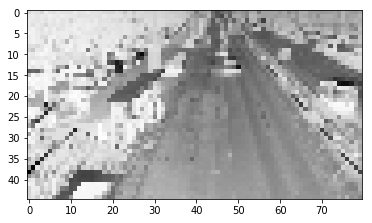

In [6]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

example = train_x[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example, cmap='Greys')

In [7]:


# Must perform normalization for the autoencoder to perform well
train_x /= 255.0
test_x /= 255.0 

In [8]:
keras.backend.clear_session()

In [9]:
# Combined network with both FC and CNN layers

n_samples, width, height, channels = train_x.shape
# Input
input_img = Input(shape=(width, height, 1))
# Encoder
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(input_img)
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(x)
x = MaxPooling2D((2,2),
                 padding='same')(x) 
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
x = MaxPooling2D((2,2),
                 padding='same')(x) # Size 
x = Flatten()(x)
encoded = Dense(256)(x)
# Decoder
x = Dense(3840)(encoded)
x = Reshape((12, 20, 16))(x)
x = UpSampling2D((2, 2))(x) # 24, 40, 16
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Size 48, 80, 16
x = Conv2D(8, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(1, (3, 3),
           activation='relu',
           padding='same')(x)

decoded = Cropping2D(cropping=((2,1),(0,0)),
               data_format='channels_last')(x) # size 45, 80, 16


autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 80, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 80, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 40, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 40, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 20, 16)        0         
__________

In [10]:
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 10s 1ms/step - loss: 0.1292 - val_loss: 0.0709
Epoch 2/200
8336/8336 [==============================] - 2s 260us/step - loss: 0.0519 - val_loss: 0.0344
Epoch 3/200
8336/8336 [==============================] - 2s 260us/step - loss: 0.0301 - val_loss: 0.0276
Epoch 4/200
8336/8336 [==============================] - 2s 266us/step - loss: 0.0264 - val_loss: 0.0223
Epoch 5/200
8336/8336 [==============================] - 2s 279us/step - loss: 0.0238 - val_loss: 0.0227
Epoch 6/200
8336/8336 [==============================] - 2s 280us/step - loss: 0.0226 - val_loss: 0.0226
Epoch 7/200
8336/8336 [==============================] - 2s 271us/step - loss: 0.0218 - val_loss: 0.0220
Epoch 8/200
8336/8336 [==============================] - 2s 268us/step - loss: 0.0212 - val_loss: 0.0213
Epoch 9/200
8336/8336 [==============================] - 2s 281us/step - loss: 0.0208 - val_loss: 0.0210
Epoch 10

Epoch 78/200
8336/8336 [==============================] - 1s 173us/step - loss: 0.0084 - val_loss: 0.0129
Epoch 79/200
8336/8336 [==============================] - 1s 174us/step - loss: 0.0083 - val_loss: 0.0132
Epoch 80/200
8336/8336 [==============================] - 1s 168us/step - loss: 0.0083 - val_loss: 0.0128
Epoch 81/200
8336/8336 [==============================] - 1s 167us/step - loss: 0.0082 - val_loss: 0.0127
Epoch 82/200
8336/8336 [==============================] - 1s 166us/step - loss: 0.0081 - val_loss: 0.0127
Epoch 83/200
8336/8336 [==============================] - 1s 164us/step - loss: 0.0081 - val_loss: 0.0127
Epoch 84/200
8336/8336 [==============================] - 1s 161us/step - loss: 0.0081 - val_loss: 0.0126
Epoch 85/200
8336/8336 [==============================] - 1s 175us/step - loss: 0.0080 - val_loss: 0.0126
Epoch 86/200
8336/8336 [==============================] - 1s 177us/step - loss: 0.0080 - val_loss: 0.0130
Epoch 87/200
8336/8336 [======================

Epoch 155/200
8336/8336 [==============================] - 2s 280us/step - loss: 0.0066 - val_loss: 0.0127
Epoch 156/200
8336/8336 [==============================] - 2s 257us/step - loss: 0.0066 - val_loss: 0.0124
Epoch 157/200
8336/8336 [==============================] - 2s 265us/step - loss: 0.0065 - val_loss: 0.0124
Epoch 158/200
8336/8336 [==============================] - 2s 268us/step - loss: 0.0065 - val_loss: 0.0126
Epoch 159/200
8336/8336 [==============================] - 2s 294us/step - loss: 0.0065 - val_loss: 0.0124
Epoch 160/200
8336/8336 [==============================] - 2s 269us/step - loss: 0.0065 - val_loss: 0.0127
Epoch 161/200
8336/8336 [==============================] - 2s 250us/step - loss: 0.0065 - val_loss: 0.0123
Epoch 162/200
8336/8336 [==============================] - 2s 273us/step - loss: 0.0065 - val_loss: 0.0127
Epoch 163/200
8336/8336 [==============================] - 2s 294us/step - loss: 0.0065 - val_loss: 0.0124
Epoch 164/200
8336/8336 [============

In [11]:
# After downsizing the images, we need to cluster them by similarity
# Heuristic we will use is to assume fps rate is 20. We will make num_samples / 20 clusters

# Apply hierarchical clustering
# Remember the indexes
# Put the images into correct locations
# TODO: Currently the images are not being divided correctly... We need to find out why

from sklearn.cluster import AgglomerativeClustering

#image_table_flattened = image_table.reshape(-1, width*height).astype('float32')
#image_table /= 255.0

images_compressed = encoder.predict(image_table)

#n_samples, width , height, channels = images_compressed.shape
#print(n_samples, width, height, channels)
# flatten the image 
#images_compressed = images_compressed.reshape(n_samples, width*height*channels);

print(images_compressed.shape)

fps = 20
ac = AgglomerativeClustering(n_clusters=len(images_compressed) // fps)

start_time = time.time()
ac.fit(images_compressed)
print("Time to fit ", n_samples, ": ", time.time() - start_time)
images_label = ac.labels_

print(min(images_label))
print(max(images_label))


(10421, 256)
Time to fit  8336 :  19.88397789001465
0
520


In [12]:
images_decoded = autoencoder.predict(image_table)

0
(45, 80)
(45, 80)
2
(45, 80)
(45, 80)
4
(45, 80)
(45, 80)
6
(45, 80)
(45, 80)
8
(45, 80)
(45, 80)


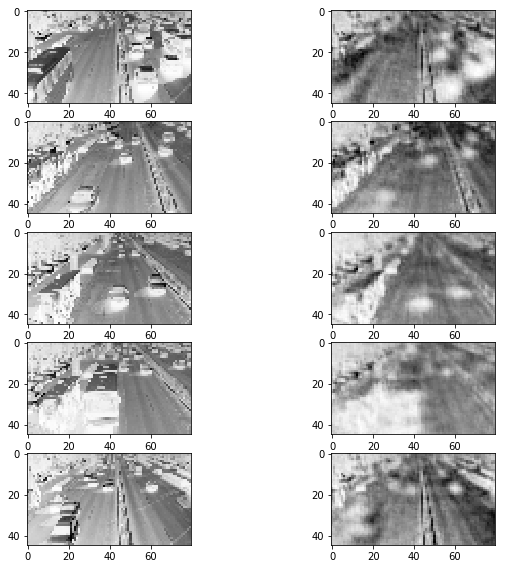

In [13]:
# Let's display the original image and the decoded image side by side
# We will randomly draw 5 images

import matplotlib.pyplot as plt
import random
n_samples, width, height, channels = image_table.shape

fig=plt.figure(figsize=(10, 20))
columns = 2
rows = 10


for idx in range(0, rows, 2):
    fig.add_subplot(rows, columns, idx + 1)
    #a = cv2.imread(image)
    random_index = random.randint(0, len(image_table))
    original = np.copy(image_table[random_index])
    original *= 255.0
    original = np.squeeze(original)
    original = original.astype('int32')
    print(idx)
    #print(original)
    print(original.shape)
    width, height = original.shape
    
    plt.imshow(original, cmap='Greys')
    fig.add_subplot(rows, columns, idx + 2)
    decoded = np.copy(images_decoded[random_index])
    decoded *= 255.0
    decoded = np.squeeze(decoded)
    decoded = decoded.astype('int32')
    decoded = decoded.reshape(width, height)
    print(decoded.shape)
    plt.imshow(decoded, cmap='Greys')
    
plt.show()

Text(0, 0.5, 'Number of datapoints')

/nethome/jbang36/anaconda3/envs/jb_py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


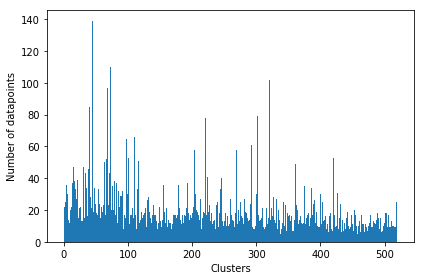

In [14]:
# I think it is best to see the distributions

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(images_label, bins=max(images_label) + 1)
plt.xlabel("Clusters")
plt.ylabel("Number of datapoints")

In [16]:
# Copy original data to the new clusters

from shutil import copyfile

os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')

mvi_folders = os.listdir(data_dir)
print(mvi_folders)
mvi_folders.sort()

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-cae-clusters')
    
total_cluster_count = 0    
offset = 0
for i in range(len(mvi_folders)):
    image_files = os.listdir(os.path.join(data_dir, mvi_folders[i]))
    image_files.sort()
    print("length of image_files in directory", mvi_folders[i], "is ", len(image_files))
    for j in range(len(image_files)):
        src = os.path.join(data_dir, mvi_folders[i], image_files[j])
        
        cluster_dir = os.path.join(cluster_dir_pre, str(images_label[offset+j]))
        dst = os.path.join(cluster_dir, image_files[j])
        if not os.path.exists(cluster_dir):
            os.mkdir(cluster_dir)
            total_cluster_count += 1
        #print(src)
        #print(dst)
        copyfile(src, dst)
        
    offset += len(image_files)

print("Done copying all files")
print("Number of clusters made:", total_cluster_count)

['MVI_20064', 'MVI_20062', 'MVI_20032', 'MVI_20011', 'MVI_20051', 'MVI_20034', 'MVI_20033', 'MVI_20012', 'MVI_20061', 'MVI_20065', 'MVI_20052', 'MVI_20063', 'MVI_20035']
length of image_files in directory MVI_20011 is  664
length of image_files in directory MVI_20012 is  936
length of image_files in directory MVI_20032 is  437
length of image_files in directory MVI_20033 is  784
length of image_files in directory MVI_20034 is  800
length of image_files in directory MVI_20035 is  800
length of image_files in directory MVI_20051 is  906
length of image_files in directory MVI_20052 is  694
length of image_files in directory MVI_20061 is  800
length of image_files in directory MVI_20062 is  800
length of image_files in directory MVI_20063 is  800
length of image_files in directory MVI_20064 is  800
length of image_files in directory MVI_20065 is  1200
Done copying all files
Number of clusters made: 521


15


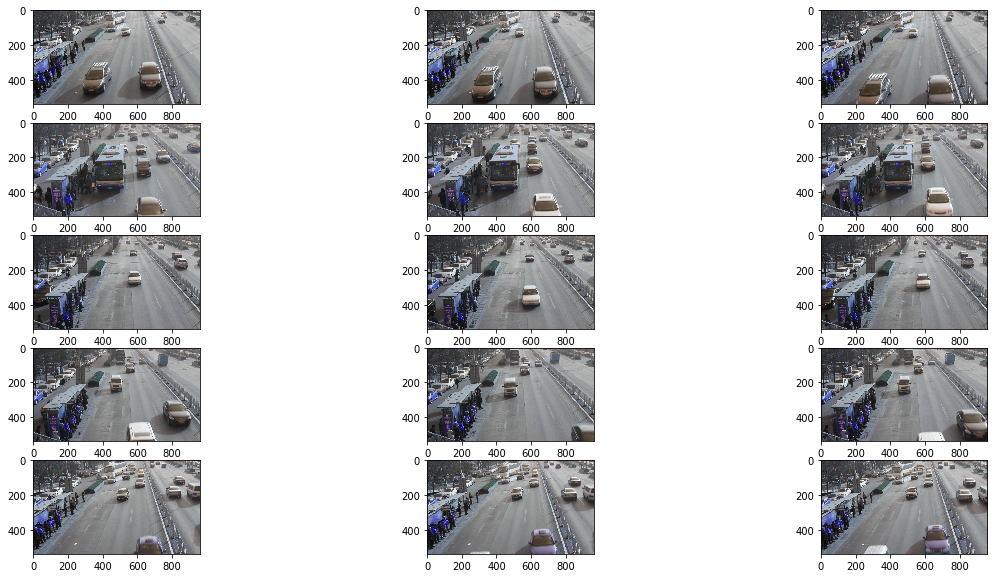

In [17]:
# UTIL: Plot the images that belong in the same cluster and different clusters
# We will select 3 from each directory

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-cae-clusters')
cluster_nums = os.listdir(cluster_dir_pre)

# I would love to display all the clusters but for now let's just pick 10


full_paths = []
for i in range(5):
    cluster_dir = os.path.join(cluster_dir_pre, str(cluster_nums[i]))
    image_files = os.listdir(cluster_dir)
    for j in range(3):
        full_paths.append(os.path.join(cluster_dir, image_files[j]))

        
print(len(full_paths))
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(20, 10))
columns = 3
rows = 5

for idx, image in enumerate(full_paths):
    fig.add_subplot(rows, columns, idx + 1)
    a = cv2.imread(image)
    plt.imshow(a)
plt.show()
    

In [ ]:
##### Model Library ######

# 1. Upsample

# convolutional autoencoder with FC layers - deconvolution with upsampling layers

n_samples, width, height, channels = train_x.shape
# Input
input_img = Input(shape=(width, height, 1))
# width = 540
# height = 960
# Encoder
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(input_img)
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = MaxPooling2D((2,2),
                 padding='same',
                 data_format='channels_last')(x) 
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = MaxPooling2D((2,2),
                 padding='same',
                 data_format='channels_last')(x) 
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = MaxPooling2D((2,2),
                    padding='same',
                    data_format='channels_last')(x) 

x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
# Encoded layer, Size 16x4x4
encoded = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)

# Decoder
x = Conv2D(16, (3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(encoded)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = UpSampling2D((2,2),
                 data_format='channels_last')(x)
x = Conv2D(16, (3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = UpSampling2D((2,2),
                 data_format='channels_last')(x) 
x = Conv2D(16, (3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = UpSampling2D((2,2),
                 data_format='channels_last')(x) 
x = Conv2D(8, (3,3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x)
x = Conv2D(8, (3, 3),
           activation='relu',
           padding='same',
           data_format='channels_last')(x) 
x = Conv2D(1, (1,1),
         padding='same',
         activation='sigmoid',
         data_format='channels_last')(x) 


decoded = Cropping2D(cropping=((2,1),(0,0)),
               data_format='channels_last')(x)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


